# Hyperparameter Tuning

## Experiment
The goal of the third experiment is to find the best combination of hyperparameters across a range of different regressor models. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. April, 2017, thus covering all seasons. April of 2017 was the first whole month with Level-2A imagery and the closest to the recording dates.
- Level-2A Sentinel 2 satellite imagery and indices, using the reducers and numbers of composites determined by the previous experiment are used as input features.
- The evaluation metric for the models is RMSE (Root Mean Squared Error).

The hyperparameter optimization is done using Bayesian Optimization with Optuna. The optuna studies and the best pipeline obects are saved using dill instead of pickle to support lambda functions.

At first we train a baseline model using simple data. We use a random forest model with default parameters and use all spectral Level-2A bands (starting with "B") averaged across the study timewindow as the data.

In [1]:
# Create a baseline composite from a Sentinel image with the average across 1 year
from ltm.data import sentinel_composite, list_bands
from datetime import datetime
from pathlib import Path
from sklearn.metrics import make_scorer, mean_squared_error
from ltm.features import load_raster, drop_nan_rows
from sklearn.model_selection import cross_validate

rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
data_path = "../data/processed/hyperparameter_tuning/data.tif"
target_path = "../data/processed/ground_truth/target.tif"

# Create the composite if it does not exist
if not Path(data_path).exists():
    # List all available Sentinel 2 Level-2A bands
    bands = list_bands()
    b_bands = [band for band in bands if band.startswith("B")]

    Path(data_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=data_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
        sentinel_bands=b_bands,
    )

# Compare it to the baseline
from sklearn.ensemble import RandomForestRegressor

data = load_raster(data_path)
target = load_raster(target_path)

data = data.dropna(axis=1)
data, target = drop_nan_rows(data, target)

cv_result = cross_validate(RandomForestRegressor(n_jobs=-1, random_state=42), data, target, cv=5, scoring=rmse_scorer, n_jobs=-1)
score = cv_result["test_score"].mean()

print(f"Baseline RMSE: {-score}")

Baseline RMSE: 0.30346329731474664


In [2]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

In [3]:
# Define the metric and load the data
from sklearn.metrics import make_scorer, mean_squared_error
from ltm.features import load_raster, drop_nan_rows

# Define the metric
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Load the data
data_path = "../data/processed/reducer_composites/data.tif"
target_path = "../data/processed/ground_truth/target.tif"
data = load_raster(data_path)
target = load_raster(target_path)

# Remove NaN columns from data and drop rows with NaN in target
data = data.dropna(axis=1)
data, target = drop_nan_rows(data, target)

In [4]:
# Create save folder and wrapper functions
from pathlib import Path

save_folder = "../models/"
Path(save_folder).mkdir(parents=True, exist_ok=True)

def suggest_categorical(*args, **kwargs):
    return "suggest_categorical", args, kwargs

def suggest_discrete_uniform(*args, **kwargs):
    return "suggest_discrete_uniform", args, kwargs

def suggest_float(*args, **kwargs):
    return "suggest_float", args, kwargs

def suggest_int(*args, **kwargs):
    return "suggest_int", args, kwargs

In [5]:
from skelm import ELMRegressor
from ltm.models import hyperparam_search

elm_default = ELMRegressor(random_state=42)
search_space = [
    suggest_float("alpha", 1e-8, 1e5, log=True),
    suggest_categorical("include_original_features", [True, False]),
    suggest_float("n_neurons", 1, 1000),
    suggest_categorical("ufunc", ["tanh", "sigm", "relu", "lin"]),
    suggest_float("density", 0.01, 0.99),
]

elm_model, elm_study = hyperparam_search(
    elm_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42
)
elm_model

Files already exist, skipping search: ..\models\ELMRegressor_study.pkl, ..\models\ELMRegressor.pkl


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ELMRegressor(alpha=113.80934300804698,
                              density=0.05030564945688226,
                              n_neurons=808.798569807405, random_state=42,
                              ufunc='sigm'))])

In [6]:
from sklearn.ensemble import ExtraTreesRegressor
from ltm.models import hyperparam_search

et_default = ExtraTreesRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 1, 200),
    suggest_float("min_impurity_decrease", 1e-5, 0.5, log=True),
    suggest_categorical("criterion", ["squared_error", "absolute_error"]),
]

et_model, et_study = hyperparam_search(
    et_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42
)
et_model

Files already exist, skipping search: ..\models\ExtraTreesRegressor_study.pkl, ..\models\ExtraTreesRegressor.pkl


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(min_impurity_decrease=0.00029930879167506033,
                                     n_estimators=177, n_jobs=-1,
                                     random_state=42))])

In [7]:
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from ltm.models import hyperparam_search

hgbr_default = HistGradientBoostingRegressor(random_state=42)
search_space = [
    suggest_int("max_iter", 100, 1000),
    suggest_float("learning_rate", 0.001, 0.5, log=True),
    suggest_int("max_leaf_nodes", 2, 1000),
    suggest_categorical("l2_regularization", [0, 1e-10, 1e-5, 1e-3, 1e-1, 1]),
]

hgbr_model, hgbr_study = hyperparam_search(
    hgbr_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42
)
hgbr_model

Files already exist, skipping search: ..\models\HistGradientBoostingRegressor_study.pkl, ..\models\HistGradientBoostingRegressor.pkl


Pipeline(steps=[('model',
                 HistGradientBoostingRegressor(l2_regularization=1e-05,
                                               learning_rate=0.03730528349992048,
                                               max_iter=465, max_leaf_nodes=7,
                                               random_state=42))])

In [8]:
# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsRegressor
from ltm.models import hyperparam_search

knn_default = KNeighborsRegressor(n_jobs=-1)
search_space = [
    suggest_int("n_neighbors", 1, 100),
    suggest_categorical("weights", ["uniform", "distance"]),
    suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
]

knn_model, knn_study = hyperparam_search(
    knn_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42
)
knn_model

Files already exist, skipping search: ..\models\KNeighborsRegressor_study.pkl, ..\models\KNeighborsRegressor.pkl


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=13)),
                ('model',
                 KNeighborsRegressor(algorithm='brute', n_jobs=-1,
                                     n_neighbors=27, weights='distance'))])

In [9]:
from sklearn.ensemble import RandomForestRegressor
from ltm.models import hyperparam_search
from sklearn.model_selection import cross_validate

rf_default = RandomForestRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 1, 200),
    suggest_int("max_depth", 1, 1000),
    suggest_float("max_features", 0.1, 1.0),
    suggest_float("min_samples_split", 1e-5, 0.5, log=True),
    suggest_float("min_samples_leaf", 1e-5, 0.5, log=True),
    suggest_categorical("bootstrap", [True, False]),
    suggest_categorical("criterion", ["squared_error", "absolute_error", "poisson", "friedman_mse"]),
]

rf_model, rf_study = hyperparam_search(
    rf_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42
)
rf_model

Files already exist, skipping search: ..\models\RandomForestRegressor_study.pkl, ..\models\RandomForestRegressor.pkl


Pipeline(steps=[('model',
                 RandomForestRegressor(criterion='poisson', max_depth=331,
                                       max_features=0.15001729207226336,
                                       min_samples_leaf=0.00885044744067833,
                                       min_samples_split=4.915224710236927e-05,
                                       n_estimators=194, n_jobs=-1,
                                       random_state=42))])

In [10]:
# SGD Linear Regression
from sklearn.linear_model import SGDRegressor
from ltm.models import hyperparam_search

sgd_default = SGDRegressor(random_state=42)
search_space = [
    suggest_categorical("loss", ["squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]),
    suggest_float("alpha", 1e-6, 1e5, log=True),
    suggest_float("l1_ratio", 0, 1),
]

sgd_model, sgd_study = hyperparam_search(
    sgd_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42
)
sgd_model

Files already exist, skipping search: ..\models\SGDRegressor_study.pkl, ..\models\SGDRegressor.pkl


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SGDRegressor(alpha=12.000236477722126,
                              l1_ratio=0.766902183829234, loss='huber',
                              random_state=42))])

In [11]:
# Support Vector Machine
from sklearn.svm import SVR
from ltm.models import hyperparam_search

svr_default = SVR()
search_space = [
    suggest_float("C", 1e-5, 1e5, log=True),
    suggest_float("epsilon", 1e-5, 1e5, log=True),
    suggest_categorical("kernel", ["poly", "rbf", "sigmoid"]),
]

svr_model, svr_study = hyperparam_search(
    svr_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42
)
svr_model

Files already exist, skipping search: ..\models\SVR_study.pkl, ..\models\SVR.pkl


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVR(C=0.48871291289434515, epsilon=1.3204105135048942e-05))])

In [12]:
from xgboost import XGBRegressor
from ltm.models import hyperparam_search

xgb_default = XGBRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 10, 200),
    suggest_int("max_depth", 1, 20),
    suggest_float("learning_rate", 0.001, 0.5, log=True),
    suggest_float("gamma", 0, 0.5),
    suggest_int("min_child_weight", 1, 11),
]

xgb_model, xgb_study = hyperparam_search(
    xgb_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42
)
xgb_model

Files already exist, skipping search: ..\models\XGBRegressor_study.pkl, ..\models\XGBRegressor.pkl


Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.05059579792004068,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.04010142020887353, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=11, missing=nan,
                              monotone_constraints=None, n_estimators=169,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=42, ...))])

In [13]:
import pandas as pd

csv_path = "../reports/hyperparameter_tuning.csv"
studies = [
    elm_study,
    et_study,
    hgbr_study,
    knn_study,
    rf_study,
    sgd_study,
    svr_study,
    xgb_study,
]

if not Path(csv_path).exists():
    default_models = [
        elm_default,
        et_default,
        hgbr_default,
        knn_default,
        rf_default,
        sgd_default,
        svr_default,
        xgb_default,
    ]
    models = [
        elm_model,
        et_model,
        hgbr_model,
        knn_model,
        rf_model,
        sgd_model,
        svr_model,
        xgb_model
    ]
    max_scores = {
        study.study_name: -study.best_value for study in studies
    }

    # Get the scores for default models
    model_names = [model.__class__.__name__ for model in default_models]
    scores = [-cross_validate(model, data, target, scoring=rmse_scorer, n_jobs=-1)["test_score"].mean() for model in default_models]

    df = pd.DataFrame({
        "Model": model_names,
        "Default Score": scores,
        "Best Score": [max_scores[model_name] for model_name in model_names]
    })
    df.set_index("Model", inplace=True)
    df.to_csv(csv_path)
else:
    df = pd.read_csv(csv_path, index_col="Model")

df

,Default Score,Best Score
Model,,
ELMRegressor,4.716733e+01,0.259671
ExtraTreesRegressor,2.577899e-01,0.253256
HistGradientBoostingRegressor,2.606966e-01,0.253539
KNeighborsRegressor,4.653962e-01,0.261811
RandomForestRegressor,2.587596e-01,0.254304
SGDRegressor,2.714701e+36,0.279318
SVR,5.282818e-01,0.255913
XGBRegressor,2.664698e-01,0.251433


In [14]:
df.loc["SVR"]["Default Score"]

0.5282817585031522

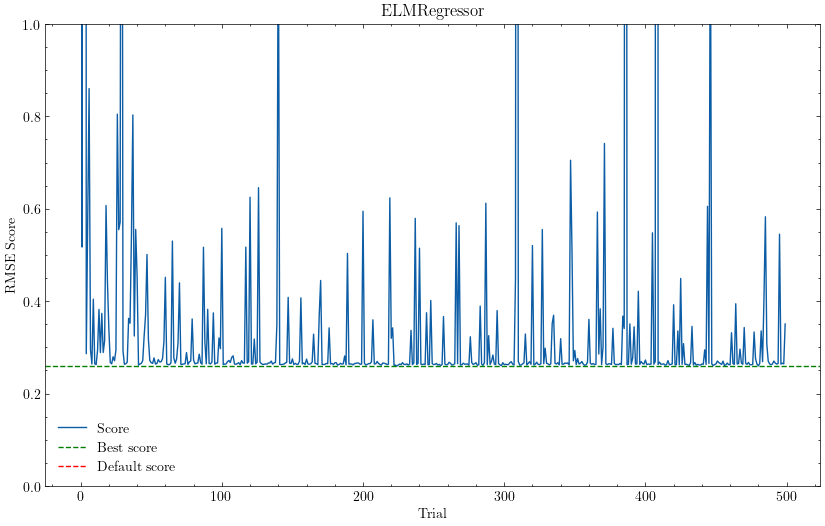

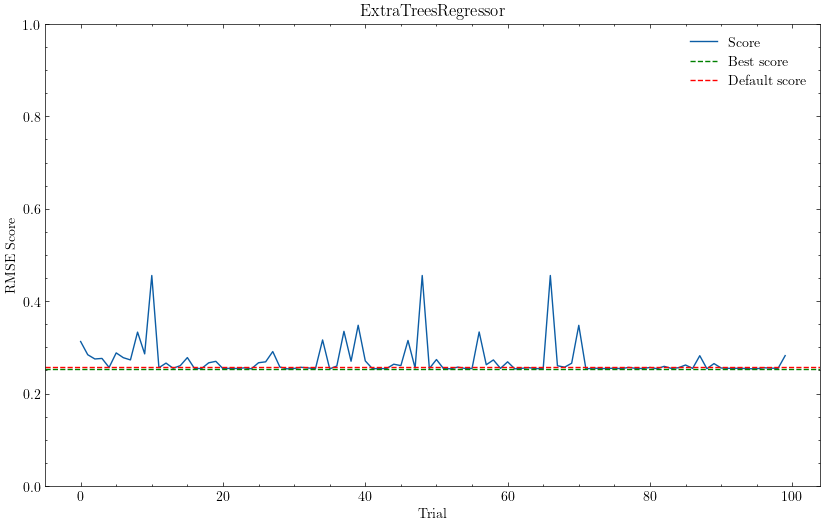

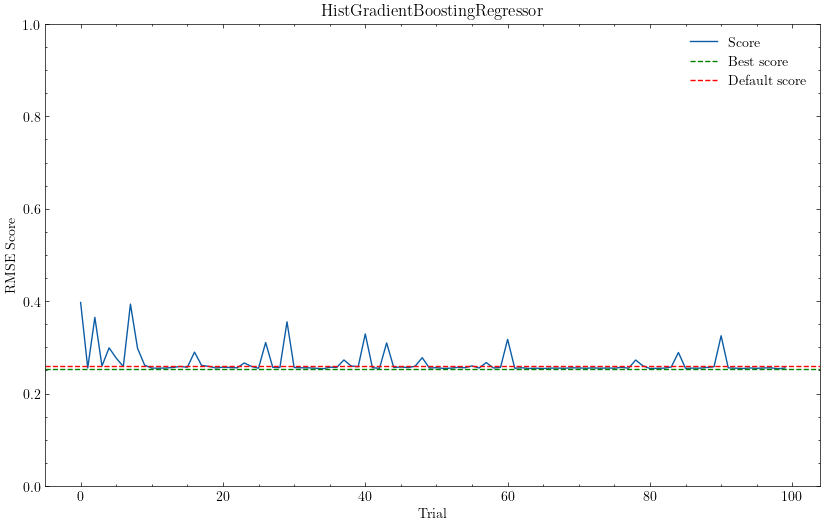

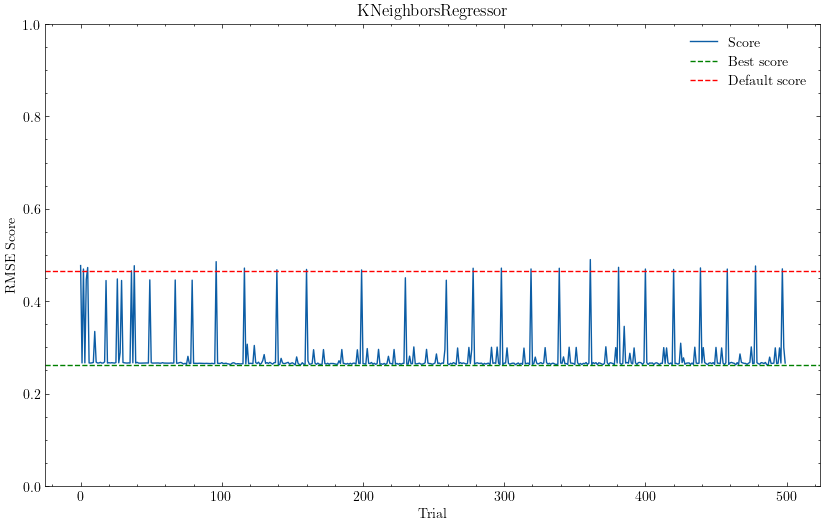

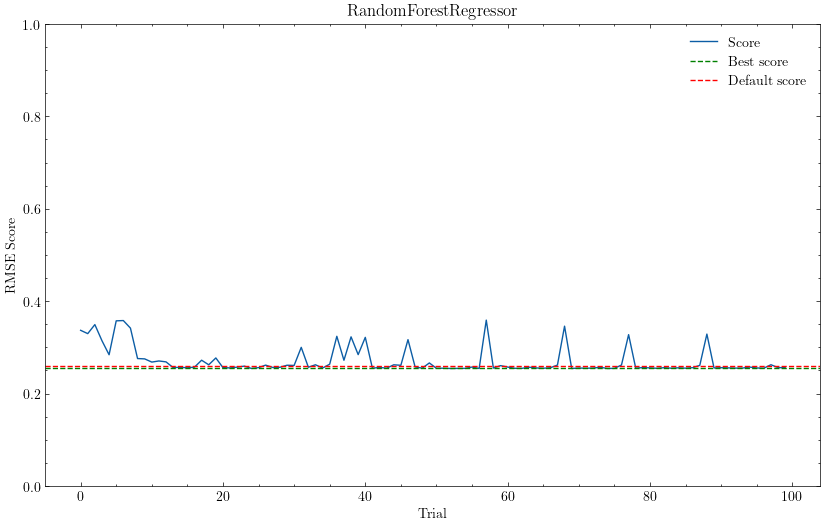

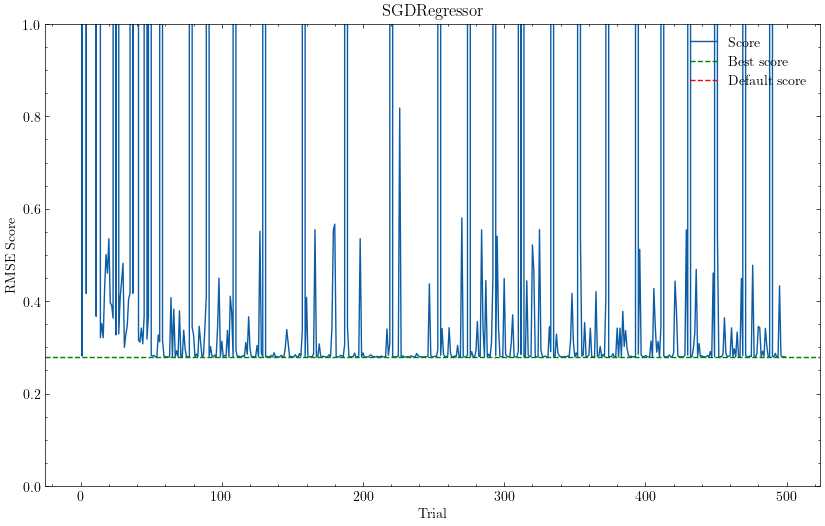

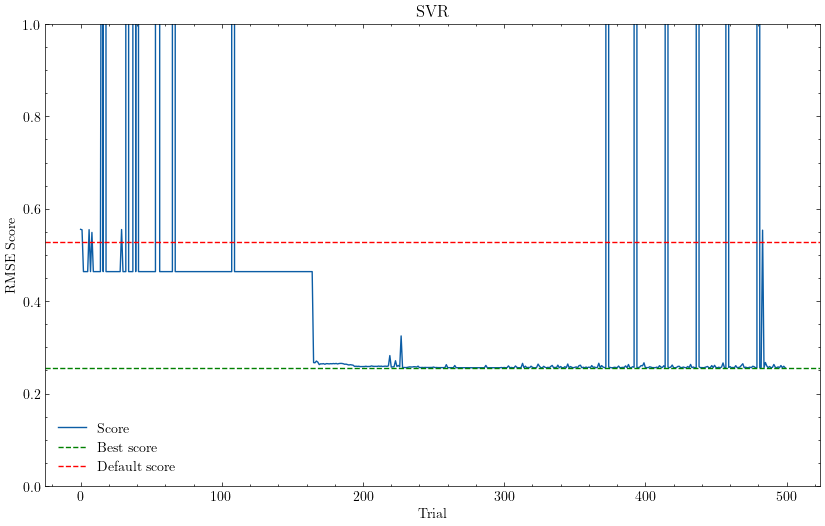

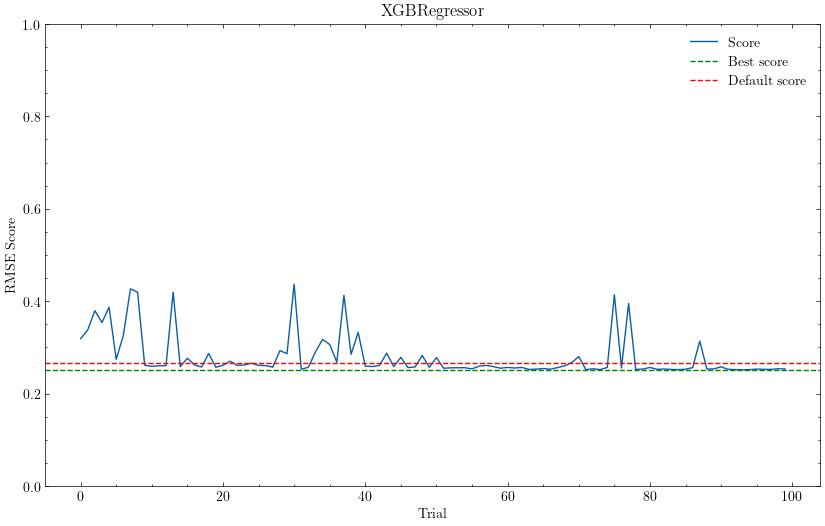

In [15]:
# Plot the hyperparam search scores during search with performance of baseline models as reference
for study in studies:
    trials = study.trials_dataframe()
    plt.figure(figsize=(10, 6))
    plt.plot(-trials['value'], label='Score')
    plt.title(study.study_name)
    plt.xlabel("Trial")
    plt.ylabel("RMSE Score")
    plt.axhline(df.loc[study.study_name]["Best Score"], color='g', linestyle='--', label='Best score')
    plt.axhline(df.loc[study.study_name]["Default Score"], color='r', linestyle='--', label='Default score')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()